In [1]:
import os
import cv2
import json
import torch
import imutils
import matplotlib
import numpy as np
import pandas as pd 
from PIL import Image
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,8);

%matplotlib inline

In [2]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

In [3]:
def preprocess(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2 )
    thresh = cv2.adaptiveThreshold(blur,255,1,1,11,1)
    blur_thresh = cv2.GaussianBlur(thresh,(5,5),5)
    return blur_thresh

In [4]:
def detect_cards(image, num = None):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(1,1),1000)
    flag, thresh = cv2.threshold(blur, 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea,reverse=True)#[:numcards] 
    prev_list = []
    for i, elem in enumerate(contours):
        ar = cv2.contourArea(elem)
        if i == 0:
            pass
        else:
            prev_list.append( abs((ar - prev)/(prev+0.01)))
        prev = ar
        if i == 20:
            break
    for i, elem in enumerate(prev_list):
        if elem > 0.25:
            numcards = i+1
            break
    #print(prev_list)
    if num != None:
        numcards = num   
    print(str(numcards) + " cards detected")
    r_all = []
    for i in range(numcards):
        card = contours[i]
        peri = cv2.arcLength(card,True)
        approx = cv2.approxPolyDP(card,0.02*peri,True)
        rect = cv2.minAreaRect(contours[i])
        r = cv2.boxPoints(rect)
        r_all.append(r)
    r_sort = []
    for r in r_all:
        approx = np.array(r, dtype = np.float32)
        i = approx
        x_s = sorted(i, key=lambda x: x[1])
        y_s = sorted(i, key=lambda x: x[0])
        x_s = [list(i) for i in x_s]
        y_s = [list(i) for i in y_s]
        ll = intersection(x_s[:2], y_s[:2])
        lu = intersection(x_s[:2], y_s[2:])
        rl = intersection(x_s[2:], y_s[:2])
        ru = intersection(x_s[2:], y_s[2:])
        ordered = [ll[0], lu[0], rl[0], ru[0]]
        ordered = np.array(ordered)
        r_sort.append(ordered)
    detected = []
    for locs in r_sort:
        h = np.array([[0,0],[199, 0], [0,299],[199,299]],np.float32)
        transform = cv2.getPerspectiveTransform(locs,h)
        warp = cv2.warpPerspective(im,transform,(200,300))
        corr = []
        names = []
        for i in os.listdir(DIR_TEMP):
            if i[0] == ".":
                continue
            template = cv2.imread(DIR_TEMP + "/" + i)
            diff = cv2.absdiff(preprocess(warp),preprocess(template))  
            diff = cv2.GaussianBlur(diff,(5,5),5)    
            flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY) 
            corr.append((np.sum(diff), i))
        warp = cv2.rotate(warp, cv2.ROTATE_180)
        for i in os.listdir(DIR_TEMP):
            if i[0] == ".":
                continue
            template = cv2.imread(DIR_TEMP + "/" + i)
            diff = cv2.absdiff(preprocess(warp),preprocess(template))  
            diff = cv2.GaussianBlur(diff,(5,5),5)    
            flag, diff = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY) 
            corr.append((np.sum(diff), i))
        warp = cv2.rotate(warp, cv2.ROTATE_180)
        ans = sorted(corr,key = lambda x: x[0])
        detected.append(ans[0][1][:-4])
        
    arr_sort = []
    for i in range(len(detected)):
        arr_sort.append((detected[i], r_sort[i]))
        
    arr_sort = sorted(arr_sort, key = lambda x: x[1][0][1])
        
    detected = [i[0] for i in arr_sort]
    r_sort = [i[1] for i in arr_sort]
    return detected, r_sort

In [5]:
DIR_TEMP = "templates"

In [6]:
im = cv2.imread("test/6_2.jpg")

In [7]:
detected, r_sort = detect_cards(im)

9 cards detected


In [8]:
print(detected)

['Qd', 'Tc', 'Qh', 'Jh', '9c', '4h', 'Jc', 'Kh', '7c']


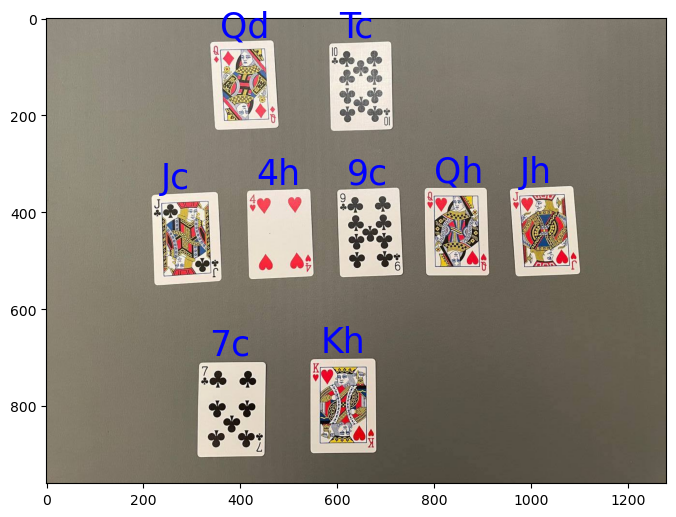

In [9]:
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

for i, elem in enumerate(r_sort):
    elem = elem[0]
    plt.text(elem[0] + 20, elem[1] - 15, detected[i], fontsize = 25, color = 'b')

In [10]:
SAVE_DIR = "outputs"

In [11]:
def save_img(im, detected, r_sort, SAVE_DIR):
    plt.ioff();
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
    ax.imshow(im_rgb)

    for i, elem in enumerate(r_sort):
        elem = elem[0]
        plt.text(elem[0] + 20, elem[1] - 15, detected[i], fontsize = 25, color = 'b')
        
    len_dir = len(os.listdir(SAVE_DIR))
    print(SAVE_DIR + "/" + str(len_dir) +".png")
    plt.savefig(SAVE_DIR + "/" + str(len_dir) +".png")  
    plt.ion();

In [12]:
save_img(im, detected, r_sort, SAVE_DIR)

outputs/6.png


In [13]:
# Calculating the rank

In [14]:
from deuces.Card import Card
from deuces.Evaluator import Evaluator

In [15]:
detected = ['Qd', 'Tc', 'Qh', 'Jc', 'Kh', '7c']

In [17]:
#pretty_cards = Card.print_pretty_cards(detected)

In [18]:
try:
    board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4]),Card.new(detected[5]),Card.new(detected[6])]
except:
    try:
        board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4]),Card.new(detected[5])]
    except:
        board = [Card.new(detected[2]),Card.new(detected[3]),Card.new(detected[4])]

pl1_hand = [Card.new(detected[0]),Card.new(detected[1])]
pl2_hand = [Card.new(detected[len(detected)-1]),Card.new(detected[len(detected)-2])]

eval = Evaluator()
score_pl1 = eval.evaluate(board, pl1_hand)
score_pl2 = eval.evaluate(board, pl2_hand)

print('First player rank: ',score_pl1)
print('Second player rank: ',score_pl2)

First player rank:  3821
Second player rank:  2656


In [19]:
Card.print_pretty_cards(pl2_hand)

  [ 7 ♣ ] , [ K ♥ ]  


In [20]:
Card.print_pretty_cards(pl1_hand)

  [ Q ♦ ] , [ T ♣ ]  
